# Representation of signals & inverse problems - G1-G2
---
## Lab 3: Source separation and sparsity


**Objective**: this lab explores a simple procedure to perform a audio source separation.


## Introduction

In [ ]:
from IPython import display

Many people listen to recorded music on an everyday basis, *e.g.*, from radio or
TV programs, compact discs, downloads, or online streaming services.
One may be interested in remixing the balance between the signal sources within the music (*e.g.*, to make the
vocals louder or suppress an unwanted sound) or in upmixing a two-channel
stereo recording to a 5.1.-channel surround sound system. We might also want to change the
spatial location of a musical instrument within the mixture. All these applications are
relatively straightforward, provided we can separate the different sound channels (stems) for
each musical audio object.


However, if we only have access to the final recorded mixture (as is usually the case),
the problem is much more challenging. To estimate the original musical sources, which would
allow us to remix, suppress or upmix the sources, we need to perform musical source
separation (MSS).


For a general source separation problem, we are given one or more mixture signals that
contain different combinations of some original source signals (see Figure
1, where four sources, i.e., vocals, drums, bass, and guitar, are all present in the mixture).
The task consists in recovering one or multiple source signals from the observed mixtures. In some cases,
this is relatively straightforward, e.g., if there are at least as many mixtures as there are
sources and if the mixing process is fixed, with no delays, filters, or nonlinear mastering.

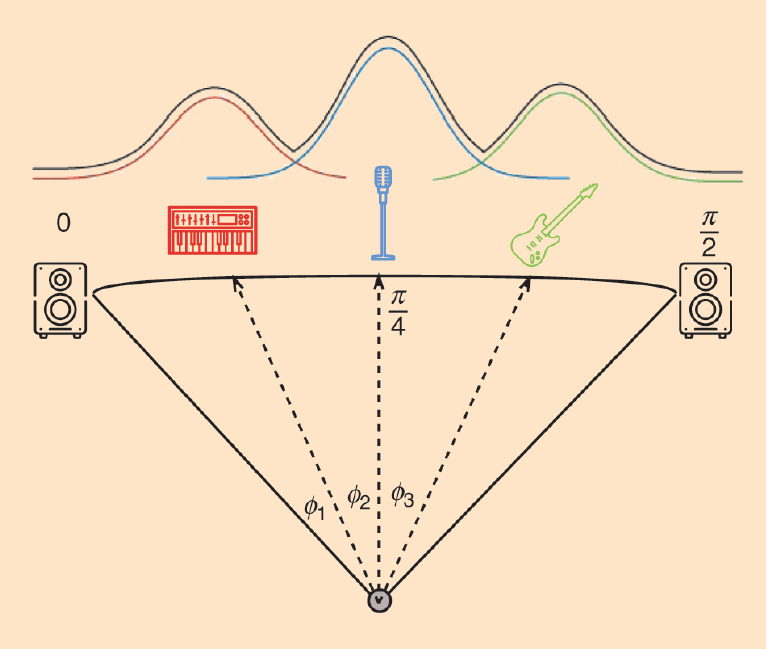

In [ ]:
display.Image("/content/BSS.PNG")

The set of individual source signals, $s(t) = (s_1(t), \dotsc, s_n(t))$ (with $n$ the number of sources), is 'mixed' through a matrix, $\mathbf{A}=[a_{ij}]_{i,j} \in \mathbb{R}^{m \times n}$, to produce a set of 'mixed' signals, $x(t)=(x_1(t), \dots, x_m(t))$ (with $m$ the number of recording channels). In practice, $n$ is often equal to $m$. If $m > n$, the system of equations is overdetermined, and can thus be inverted using a conventional linear method. If $n > m$, the system is underdetermined: a non-linear method is needed to properly recover the sources. Note that the signals themselves can be multidimensional, which is the case considered for this practical session.

Each recording channel (left and right in stereo, corresponding to the configuration illustrated above) acquires a signal of the form
$x_0(t) = \cos \phi_j s_j(t)$ and $x_1(t) = \sin\phi_j s_j(t)$ respectively, corresponding to a source $j$ in the direction $\phi_j$, for $j=0,1, \dotsc,n$. The $N$ time samples of both signals can be gathered into a matrix `x=[x[0,:]; x[1,:]]`. We then build the mixing matrix $\mathbf{A}$ from the 3 directional mixture pairs of coefficients $(\cos \phi_j, \sin\phi_j)^T$ in column $j$. Observations are thus related to the sources through the following linear equation

$$\mathbf{x} = \mathbf{A} \mathbf{s}$$

where $\mathbf{x}\in \mathbb{R}^{m\times N}$ contains the observations, $\mathbf{s}\in \mathbb{R}^{n\times N}$ contains the sources, $\mathbf{A}\in \mathbb{R}^{m\times n}$ and $N$ is the number of time samples.

The above equation will be effectively inverted using a blind source separation (BSS) approach. BSS separates the set of mixed signals $x$ through the determination of an 'unmixing' matrix $\mathbf{B} = [b_{ij}] \in \mathbb{R}^{n \times m}$, to recover an approximation to the original signals, $y(t) = (y_1(t), \dots, y_n(t))^T$.

$$\mathbf{y} = \hat{\mathbf{s}}= \mathbf{B} \mathbf{x}$$

This practical session will be focussed on a BSS approach based on 2 main ingredients. The first step consists in exploiting the redundancy of the time-frequency representation. It appears that the STFT partially separates the contribution of each source to the mixture, characterized by a distinct energy pattern in the time-frequency space (spectrogram). A second step will explore the combination of the left and right channels to estimate the direction of arrival (DOA) of each source. A clustering step will finally allow a DOA to be associated to each coefficient of the STFT of the available observations (the left and right channels). This will yield an even better separation result. An example of the kind of results expected from this approach is represented in the time-frequency plane in the figure below (each color corresponds to a different source).

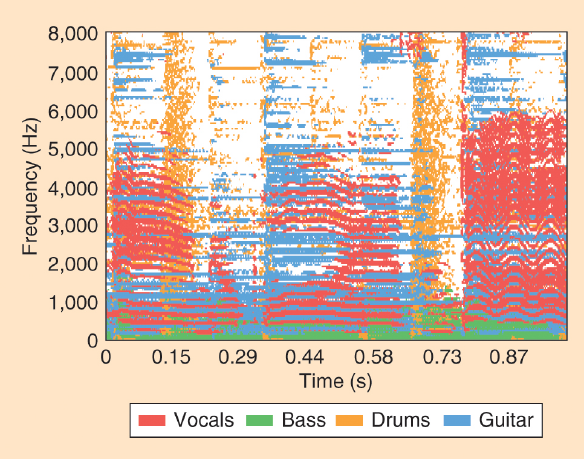

In [ ]:
display.Image("/content/TF.PNG")

------------

## A typical musical source separation (MSS) workflow
A high-level overview of the steps involved in most MSS systems is illustrated below.
The input mixture signal $x$ is first transformed to the time–frequency (TF) domain. The TF representation of the signal $X$ is then manipulated to obtain parameters that model the individual sources $\hat{S}_i$ in the mixture. These are then used to create filters to yield TF estimates $\hat{Y_i}$ of the sources. This is typically done in an iterative manner before the final estimated time domain signals $\hat{y}_i$ are recovered via an inverse TF transform.

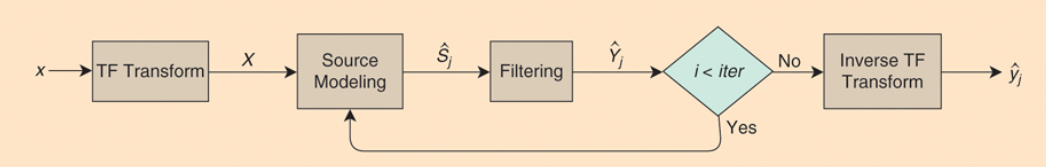

In [ ]:
display.Image("/content/workflow.PNG")

>[Representation of signals & inverse problems - G1-G2](#scrollTo=lE5R3SOibMOi)

>>[Lab 3: Source separation and sparsity](#scrollTo=lE5R3SOibMOi)

>>[Introduction](#scrollTo=aB6bvhIG_TL6)

>>[A typical musical source separation (MSS) workflow](#scrollTo=6khemcQhbMOm)

>>>>[Configuration](#scrollTo=YVGCaSivbMOn)

>>[Preparing the data: sound mixing  (↑)](#scrollTo=yGaVz26ybMOp)

>>>>[Sound loading:](#scrollTo=yGaVz26ybMOp)

>>>>[Normalize the energy of the signals](#scrollTo=HdCNLLksbMOr)

>>>>[Build the mixing matrix](#scrollTo=IkZ4vpkIbMOs)

>>>[Ready to go for music source separation !](#scrollTo=k80e4YR_bMOw)

>>[Local Fourier analysis of sounds  (↑)](#scrollTo=VAeP4Li3bMOw)

>>>[Exercise 1  (↑)](#scrollTo=YDaEjf3TbMOw)

>>[Estimation of the mixing matrix $\mathbf{A}$ by clustering  (↑)](#scrollTo=583y13CZbMOy)

>>>[Exercise 2  (↑)](#scrollTo=gjLKwwAjbMOy)

>>>[Exercise 3  (↑)](#scrollTo=W3ThWsRybMO0)

>>[Source separation using clustering  (↑)](#scrollTo=vfrRqr7mbMO1)

>>>[Exercise 4  (↑)](#scrollTo=NoP88AhEbMO2)



#### Configuration
<!-- You may need to install (if you do not use the `rsp` conda environment described above) the `scikit-image` package using either
```bash
conda install -c conda-forge scikit-image
```
or
```bash
pip install scikit-image
``` -->

In [ ]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# Uncomment the next line if you want to be able to zoom on plots (one of the options below)
# %matplotlib widget
%matplotlib inline
# %matplotlib notebook

In [ ]:
%pip install ipympl

In [ ]:
from __future__ import division

import numpy as np
import math
from scipy.signal import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from IPython.display import Audio

!pip install "ipywidgets>=7,<8"
import ipywidgets

#from nt_toolbox.general import *
#from nt_toolbox.signal import *

import warnings

warnings.filterwarnings("ignore")

In [ ]:
%run "/content/general.py"

In [ ]:
%run "/content/load_sound.py"

-----------
## Preparing the data: sound mixing <a id="section1"></a> [(&#8593;)](#content)
We first load 3 reference sounds (*sources*) and simulate a stereo recording by generating a linear mixture of the sounds.

#### Sound loading:

In [ ]:
fs = 15000

N = 1024 * 16
n = 3  # number of sounds
m = 2  # number of micros

s = np.zeros([3, N])
s[0, :] = load_sound("/content/bird.wav", N)
s[1, :] = load_sound("/content/female.wav", N)
s[2, :] = load_sound("/content/male.wav", N)

In [ ]:
Audio(s[0, :], rate=fs)

In [ ]:
Audio(s[1, :], rate=fs)

In [ ]:
Audio(s[2, :], rate=fs)

#### Normalize the energy of the signals
This normalization step is simply aimed at simulating a situation where all the sources have a similar level of energy.

In [ ]:
s = s / np.tile(np.std(s, 1), (N, 1)).T

We mix the sound using a $2 \times 3$ mixing matrix $\mathbf{A}$. The weights are determined by the direction of arrival of the acoustic wave produced by each source.
In this example, the directions are well-spaced, but you can try with more complicated
mixing matrices.

#### Build the mixing matrix

In [ ]:
phi = [np.pi / 6, np.pi / 2, np.pi * 5 / 6]  # angles = directions of arrival
print("Angles (rad) : ", phi)

Angles (rad) :  [0.5235987755982988, 1.5707963267948966, 2.6179938779914944]


Mixing matrix:

In [ ]:
A = np.vstack((np.cos(phi), np.sin(phi)))
print("A = ", A)

A =  [[ 8.66025404e-01  6.12323400e-17 -8.66025404e-01]
 [ 5.00000000e-01  1.00000000e+00  5.00000000e-01]]


Compute the mixed sources $\mathbf{x} = \mathbf{As}$.

In [ ]:
x = A.dot(s)

Display of the sources.

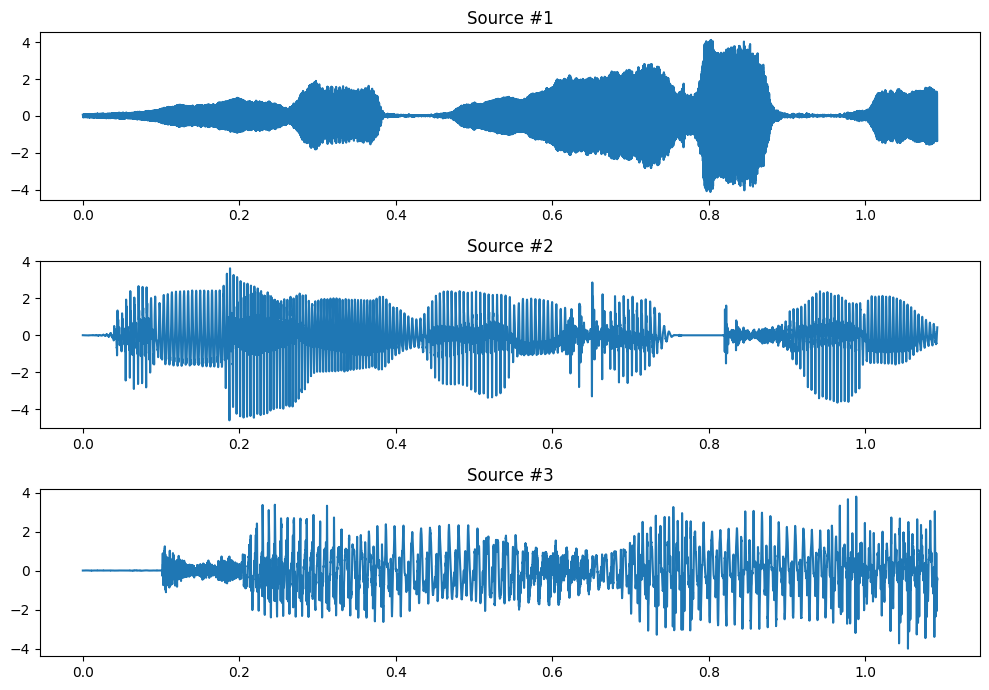

In [ ]:
plt.figure(figsize=(10, 7))
t = np.arange(0, N) / fs
for i in range(n):
    plt.subplot(n, 1, i + 1)
    plt.plot(t, s[i, :])
    plt.title("Source #%i" % (i + 1))
    plt.tight_layout()

Displaying the micros outputs (left and right channel, mixtures a several sources):

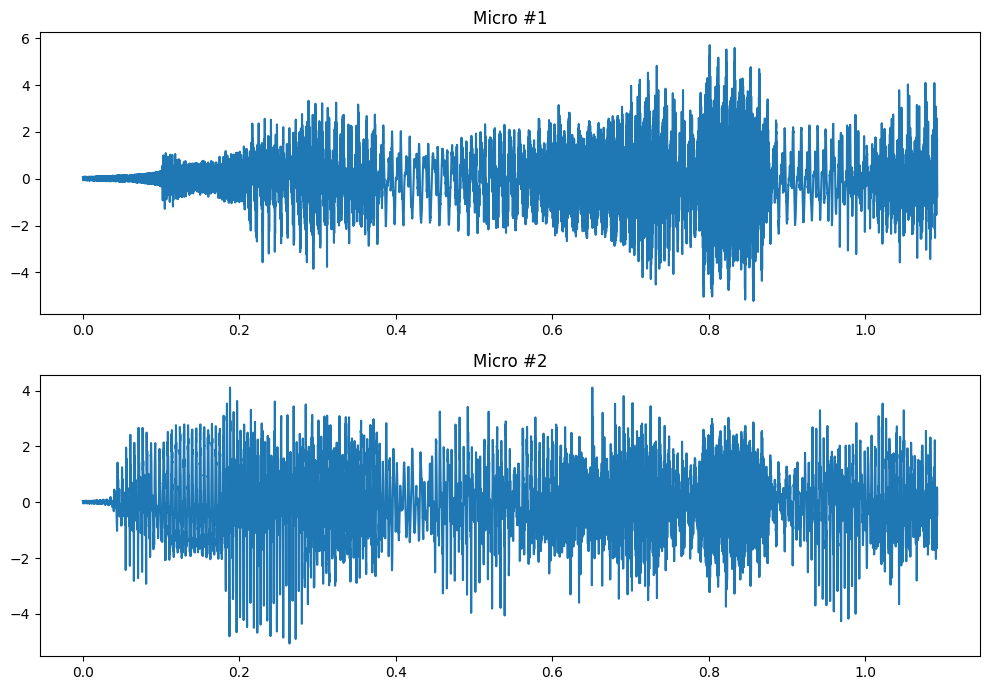

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(m):
    plt.subplot(m, 1, i + 1)
    plt.plot(t, x[i, :])
    plt.title("Micro #%i" % (i + 1))
    plt.tight_layout()

In [ ]:
Audio(x[0, :], rate=fs)

In [ ]:
Audio(x[1, :], rate=fs)

### Ready to go for music source separation !

--------------------------------
## Local Fourier analysis of sounds <a id="section2"></a> [(&#8593;)](#content)

As a first step towards source separation, we perform a short term Fourier transform (STFT) of the sounds recorded by both channels. The hope is that the sources will be well-separated over the time-frequency domain because the sources are sparse after a STFT, due to its redundancy.

In [ ]:
def myplot_spectrogram(x, fs, w, q):
    plt.figure(figsize=(10, 3))
    f, t, Zxx = stft(x, fs=fs, window="hann", nperseg=w, noverlap=q)
    plt.pcolormesh(t, f, np.abs(Zxx), cmap="jet", norm=LogNorm())
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    plt.colorbar()
    return Zxx

### Exercise 1 <a id="ex1"></a> [(&#8593;)](#content)
1. Set up the parameters for the STFT, and compute the STFT of the original sources `s`. Show their spectrogram.
2. Compute the STFT and represent the spectrogram of the 2 mixed channels `x`. Store them in an array `X` so that `X[i,:,:]` is the STFT of the channel `i`.
3. Observe and comment.

**Answers**

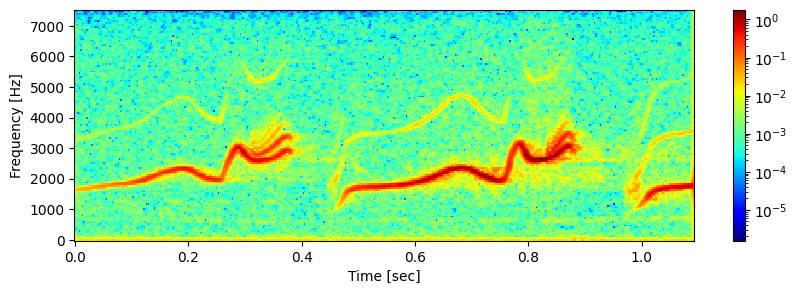

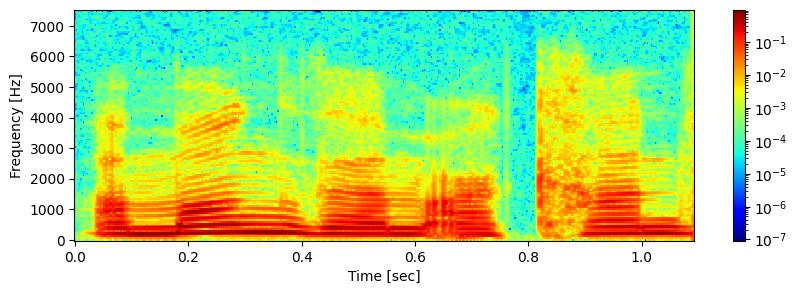

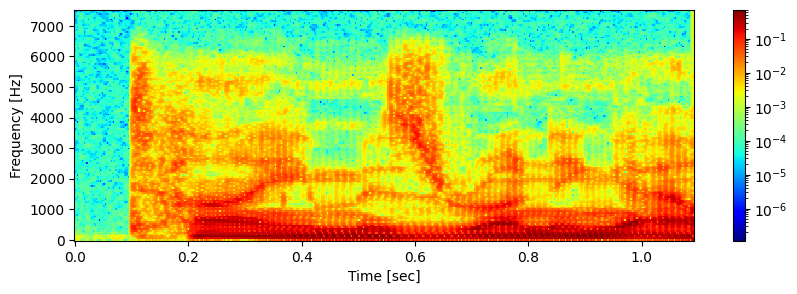

In [ ]:
# 1.

t = np.arange(0, N) / fs
#Parameters of the STFT
width = 256
spacing = width / 8

for i in range(n):
    myplot_spectrogram(s[i, :], fs, width, width - spacing)

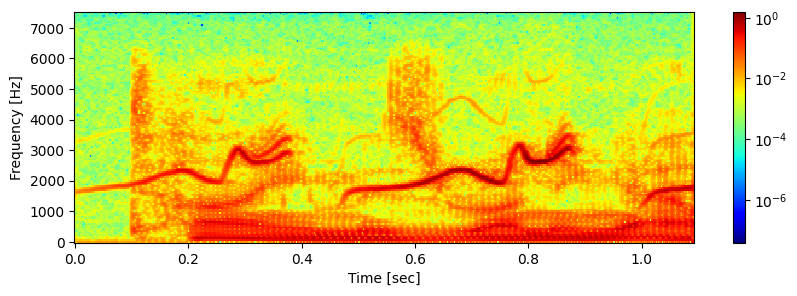

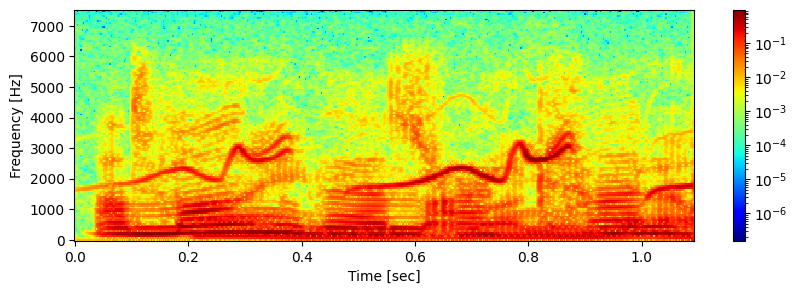

In [ ]:
# 2.

#Parameters of the STFT
width = 256
spacing = width / 8
X = np.zeros([m, width//2 + 1, width*2 + 1])

for i in range(m):
    Zxx = myplot_spectrogram(x[i, :], fs, width, width - spacing)
    X[i,:,:] = Zxx

3. The first source has very concentrated areas in the time-frequency domain, which makes it easily recognizable even in the time-frequency representation of the mixed signals. The second and third sources are harder to distinguish in as their time-frequecny representations have a lot of similarities. Looking closely to the time-frequenci representations of the mixed sources, we realize that the first microphone did not catch the second source, which is flagrant when looking at the time-frequency domain for Time < 0.1s. This is caused by the direction of arrival of this source on this microphone. As a conclusion, in this setup, the source seperation seems promising.

--------------------------------------------
## Estimation of the mixing matrix $\mathbf{A}$ by clustering <a id="section3"></a> [(&#8593;)](#content)

The sources appear to be sparse in the time-frequency plane. Now we focus on separating these even more using their direction of arrival. Indeed, considering both the left and right channels as the components of a vector, each source is expected to be aligned with one direction $(\cos\phi_j, \sin\phi_j)$ in particular.

Therefore, the STFT coefficients, at a given time and frequency in the left and right channel, are expected to be such that $X_{\mathrm{left}} = \cos\phi_j S_j$ and $X_{\mathrm{right}} = \sin\phi_j S_j$, where $S_j$ is the STFT of the source $j$. One can expect to separate the sources by identifying their direction of arrival, estimated from the ratio between the right and left channels, that is $\tan \phi_j$.

Before starting this exercise, read carefully the section `Musical source position model`, p. 35 from the supplementary article [Cano et al. 2019](https://moodle2021.centralelille.fr/pluginfile.php/9391/mod_resource/content/2/Cano%20et%20al.%20-%202019%20-%20Musical%20Source%20Separation%20An%20Introduction.pdf) (made available on Moodle).

### Exercise 2 <a id="ex2"></a> [(&#8593;)](#content)

1. In the time domain, represent `x_1 = x[1,:]` as a function of `x_0 = x[0,:]`. What do you observe? Do you think it can help in separating sources?
2. Reshape the STFTs contained in `X` (last two dimensions) to obtain a matrix `Xvec[:,i]` for `i=0,1` (i.e., `Xvec[:,i]` contains a vectorized version of the STFT of`x[i,:]`). _Indication: use `np.reshape`._
3. Concatenate the real and imaginary parts of `Xvec` along the axis 0, forming an array `Xr`.
4. Plot `Xr[:,1]` as a function of `Xr[:,0]`. Observe and comment. Do you think it can help in separating sources?
5. Compute the histogram of `arctan(Xr[:,1]/Xr[:,0])`.
6. Propose a method to estimate the direction of each source.

**Answers**

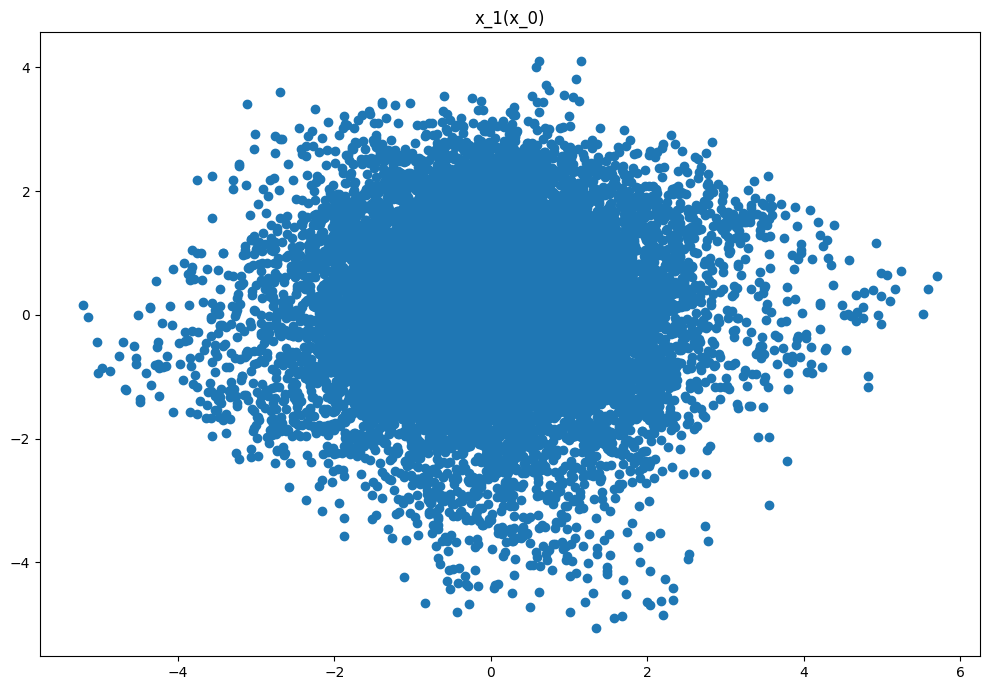

In [ ]:
# 1.

plt.figure(figsize=(10, 7))
plt.scatter(x[0, :], x[1, :])
plt.title("x_1(x_0)")
plt.tight_layout()

1. The objective is to determine the angles of arrival of each source. However, looking at the relationship between the signals received by each microphone in the time domain does not help much (cf. cell above).

In [ ]:
# 2.

L = np.shape(X)[1]*np.shape(X)[2]

X_reshape = np.zeros((2, L))
X_reshape[0] = np.reshape(X[0], L)
X_reshape[1] = np.reshape(X[1], L)

Xvec = np.transpose(X_reshape)

In [ ]:
# 3.

Xr = np.concatenate((np.real(Xvec),np.imag(Xvec)))

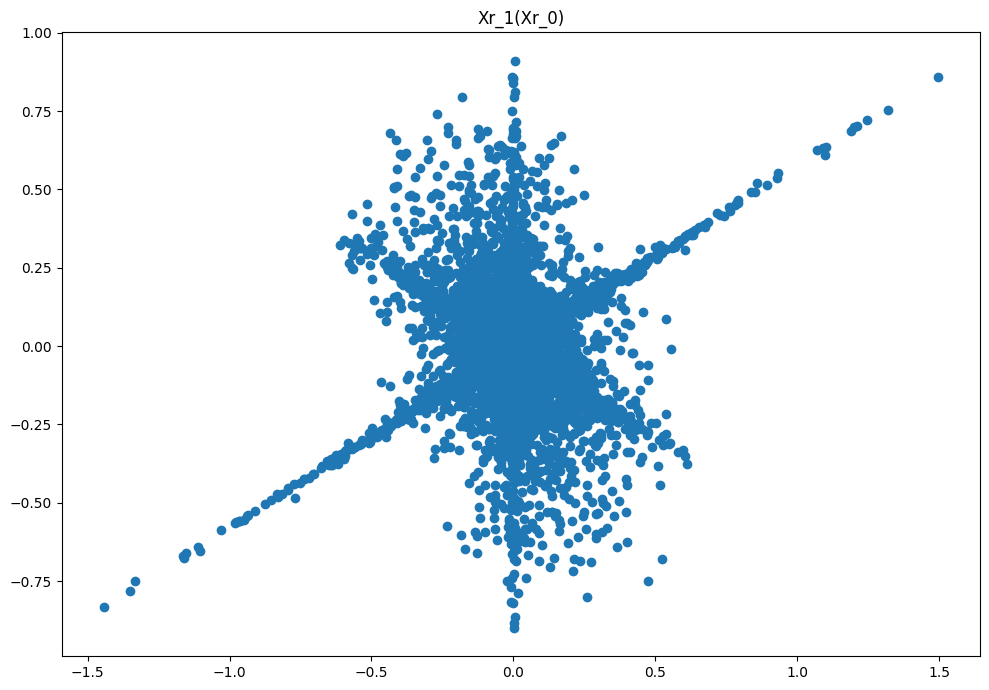

In [ ]:
# 4.

plt.figure(figsize=(10, 7))
plt.scatter(Xr[:, 0], Xr[:, 1])
plt.title("Xr_1(Xr_0)")
plt.tight_layout()

4. Looking at the Fourrier domain, one can find insights to determine the angles of arrival of the different signals. The STFT coefficients of each microphone are correlated and this correlation will help to predict the different angles of arrival of the sources (cf. scatterplot above).

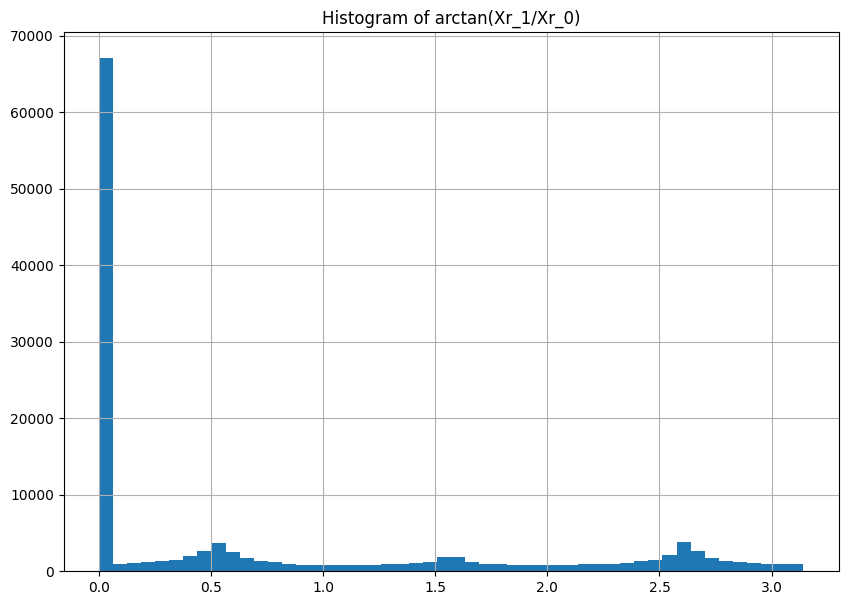

In [ ]:
# 5.

m1 = Xr.shape[0]
Xarc = np.zeros(m1)

for i in range(m1):
    Xarc[i] = np.arctan2(Xr[i,1],Xr[i,0])%np.pi

plt.figure(figsize=(10, 7))
plt.hist(Xarc,bins = 50)

plt.title('Histogram of arctan(Xr_1/Xr_0)')
plt.grid(True)
plt.show()

6. The 3 angles of arrival of the sources could be approximated by the 3 values of arctan(Xr_1/Xr_0) with the biggest densities. However, the angle phi = 0rad should be ignored as this value is taken for each null STFT coefficients, corresponding to periods of times with no energy in the specific frequency band associated to the coefficient, which is often the case in this example (cf. histogram above).

### Exercise 3 <a id="ex3"></a> [(&#8593;)](#content)
The histogram computed from the whole set of points is not peacked
enough. To stabilize the detection of the mixing directions and obtain more accurate estimates, we will compute an histogram from a reduced set of points of largest amplitude.
1. Compute the energy of each point.
2. Extract only a sub-set of the points from each STFT (left and right) by simultaneously selecting coefficients above a given energy threshold (extract the same points for both channels) .
3. Compute the histogram of the estimated directions for this subset only; you will need to empirically adjust the threshold to conduct the above step.
4. Estimate the directions of the sources as accurately as possible.
5. Compare your results with the true mixing matrix `A` and comment on them.

_Indication: the function `np.where` and `np.argmax` may help you to localize and select coefficients._

**Answers**

In [ ]:
# 1.

def energy(z):
    return np.abs(z)**2

E = energy(Xvec)

In [ ]:
# 2.

thresh = 1e-3

Xsub = np.zeros(E.shape)

j = 0
for i in range(E.shape[0]):
  if max(E[i,0],E[i,1]) > thresh:
      Xsub[j] = Xvec[i]
      j+=1

Xsub=Xsub[:j]

print(Xvec.shape)
print(Xsub.shape)

(66177, 2)
(10597, 2)


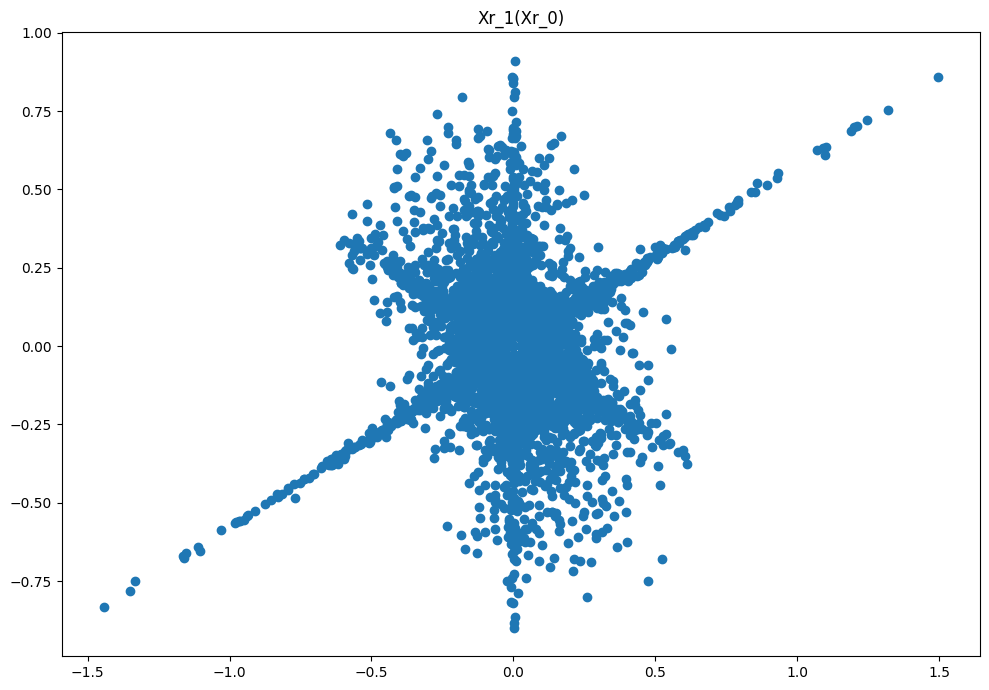

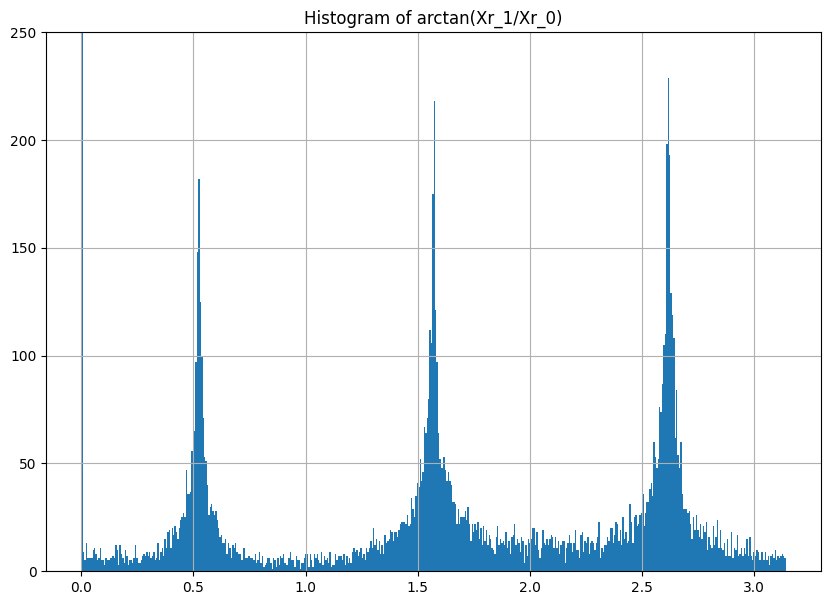

In [ ]:
# 3.

Xr = np.concatenate((np.real(Xsub),np.imag(Xsub)))

plt.figure(figsize=(10, 7))
plt.scatter(Xr[:, 0], Xr[:, 1])
plt.title("Xr_1(Xr_0)")
plt.tight_layout()
plt.show()
m1 = Xr.shape[0]
Xarc = np.zeros(m1)

for i in range(m1):
    Xarc[i] = np.arctan2(Xr[i,1],Xr[i,0])%np.pi


# the histogram of the data
bins = 500

plt.figure(figsize=(10, 7))
y_h, x_h, _ = plt.hist(Xarc,bins = bins)
plt.ylim(top=250)
plt.title('Histogram of arctan(Xr_1/Xr_0)')
plt.grid(True)
plt.show()

In [ ]:
# 4.

predicted_phi = np.zeros(3)

predicted_phi[0] = np.round((np.argmax(y_h[20:160])+20)*np.pi/bins, 3)
predicted_phi[1] = np.round((np.argmax(y_h[160:320])+160)*np.pi/bins, 3)
predicted_phi[2] = np.round((np.argmax(y_h[320:])+320)*np.pi/bins, 3)

print("The estimated angles of arrival of the sources are the following :\n{} rad\n{} rad\n{} rad"
.format(predicted_phi[0],predicted_phi[1],predicted_phi[2]))

The estimated angles of arrival of the sources are the following :
0.522 rad
1.571 rad
2.614 rad


In [ ]:
# 5.

print("The real angles of arrival of the sources are the following :\n{} rad\n{} rad\n{} rad\n\n"
.format(np.round(phi[0],3),np.round(phi[1],3),np.round(phi[2],3)))

print("The relative errors on the predicted angles are the following :\n{} %\n{} %\n{} %"
.format(np.round(100*np.abs(phi[0]-predicted_phi[0])/phi[0],2),
np.round(100*np.abs(phi[1]-predicted_phi[1])/phi[1],2),
np.round(100*np.abs(phi[2]-predicted_phi[2])/phi[2],2)))

The real angles of arrival of the sources are the following :
0.524 rad
1.571 rad
2.618 rad


The relative errors on the predicted angles are the following :
0.31 %
0.01 %
0.15 %


5. The predicted angles are very close to the real ones, with less than 0.5% error for each (cf. cell above).

---
## Source separation using clustering <a id="section4"></a> [(&#8593;)](#content)

Once the mixing directions are known, one can project the sources onto the estimated directions. The direction which best suits a given source is the one with the highest level of energy (the source is "aligned" with this direction).

We now compute the projection of the coefficients `X` onto each of the estimated directions. Each coefficient will be associated to the direction with the highest level of energy.

### Exercise 4 <a id="ex4"></a> [(&#8593;)](#content)
1. In your own words, explain and justify the proposed approach.
2. Build the estimated set of directions $\hat{\phi_k}$ and group them in a projection matrix `P`: one direction ($\cos\hat{\phi}_k, \sin\hat{\phi}_k)$ per column in a 2x3 matrix.
3. Compute the projection of each pair of coefficients (from both channels) on each direction as $ X_{\text{vec}}P$.
3. Find the closest direction of arrival associated to each point of the STFTs and give it a label $k$ to identify the corresponding direction ($\cos\hat{\phi}_k, \sin\hat{\phi}_k$) in the matrix `P`.
4. An additional denoising is achieved by removing small coefficients: we put $k=0$ for coefficients with too low energy level (use an appropriate threshold).
5. Display the index $k$ of each coefficient in the spectrogram of one channel (left or right).
6. Comment on your results.


1. Since the prediction of mixing directions has been performed, one can now try to seperate the sources by associating each STFT coefficient with a unique source. One can proceed by projecting the STFT coefficients on each direction and assume that, once projected, the remaining coefficient with the most energy would indicate the direction this STFT coefficient is associated to.

In [ ]:
# 2.

P = np.vstack((np.cos(predicted_phi), np.sin(predicted_phi)))

In [ ]:
# 3.

Xp = np.dot(Xvec,P)

In [ ]:
# 4.

coef_dir = np.zeros(len(Xp))
E_dir = energy(Xp)

for i in range(len(Xp)) :
  coef_dir[i] = np.argmax(E_dir[i])+1

In [ ]:
# 5.

thres2 = 1e-4

for i in range(len(coef_dir)) :
  if max(E[i][0], E[i][1]) < thres2 :
    coef_dir[i] = 0

print(np.count_nonzero(coef_dir == 0))
print(np.count_nonzero(coef_dir == 1))
print(np.count_nonzero(coef_dir == 2))
print(np.count_nonzero(coef_dir == 3))

46934
4302
6519
8422


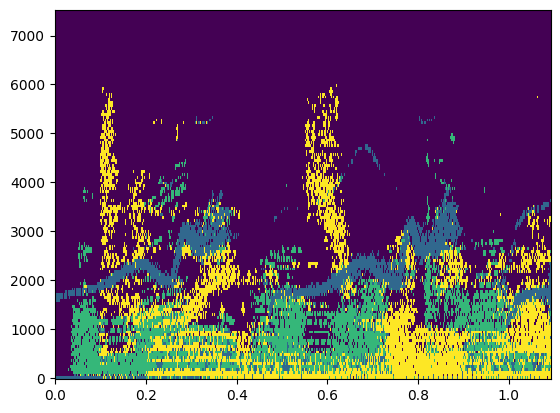

In [ ]:
# 6. Spectrogram of the right channel

coef_dir_reshape = coef_dir.reshape(129,513)

def myplot_spectrogram_2(dir_list):
    width = 256
    spacing = width / 8
    f, t, Zxx = stft(x, fs=fs, window="hann", nperseg=width, noverlap=width-spacing)
    fig, ax = plt.subplots()
    ax.pcolormesh(t, f, dir_list)
    #plt.ylabel("Frequency [Hz]")
    #plt.xlabel("Time [sec]")
    #plt.colorbar()

myplot_spectrogram_2(coef_dir_reshape)

7. The sources recovered look like the original ones. The value of the threshold has to be chosen carefully. If too high : characteristic time-frequency content of the sources will be missing, if too low : there will be "noise" on the reconstructed sources.